In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import glob
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [3]:
size = 150
batch_size = 32
img_height = size
img_width = size

In [20]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    class_names=['resized burro', 'resized capivara'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 674 files belonging to 2 classes.
Using 540 files for training.


In [21]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    class_names=['resized burro', 'resized capivara'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 674 files belonging to 2 classes.
Using 134 files for validation.


In [38]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(ds_validation))

Number of training samples: 17
Number of validation samples: 5


In [39]:
for images, labels in ds_validation:
    print(labels)
    
validation_ds = ds_validation.unbatch()
images = list(validation_ds.map(lambda x, y: x))
labels = list(validation_ds.map(lambda x, y: y))

tf.Tensor([0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1], shape=(32,), dtype=int32)
tf.Tensor([0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 1 1 1], shape=(6,), dtype=int32)


In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/20
17/17 [==============================] - 36s 2s/step - loss: 0.3870 - binary_accuracy: 0.8241 - val_loss: 0.2028 - val_binary_accuracy: 0.9328
Epoch 2/20
17/17 [==============================] - 35s 2s/step - loss: 0.1791 - binary_accuracy: 0.9259 - val_loss: 0.1459 - val_binary_accuracy: 0.9478
Epoch 3/20
17/17 [==============================] - 36s 2s/step - loss: 0.1455 - binary_accuracy: 0.9481 - val_loss: 0.1274 - val_binary_accuracy: 0.9328
Epoch 4/20
17/17 [==============================] - 36s 2s/step - loss: 0.1174 - binary_accuracy: 0.9519 - val_loss: 0.1140 - val_binary_accuracy: 0.9403
Epoch 5/20
17/17 [==============================] - 35s 2s/step - loss: 0.1104 - binary_accuracy: 0.9500 - val_loss: 0.1078 - val_binary_accuracy: 0.9403
Epoch 6/20
17/17 [==============================] - 35s 2s/step - loss: 0.1014 - binary_accuracy: 0.9611 - val_loss: 0.1078 - val_binary_accuracy: 0.9403
Epoch 7/20
17/17 [==============================] - 35s 2s/step - loss: 0.09

In [14]:
model.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/model_balanced.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
model_2 = tf.keras.models.load_model('C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/model_balanced.h5')

In [15]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['binary_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

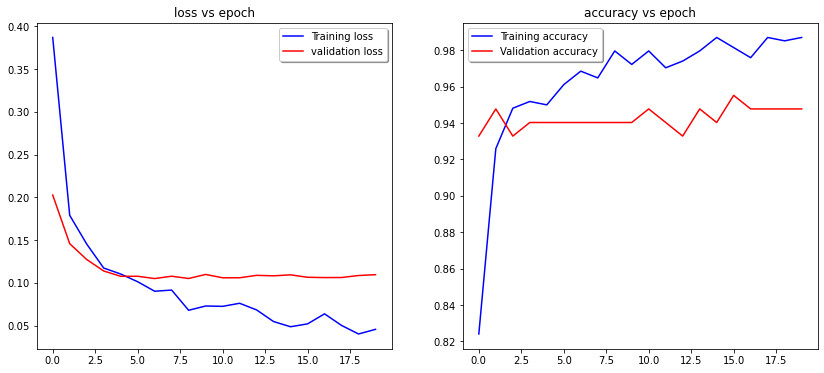

In [25]:
plotLearningCurves(history) 

In [45]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_fine = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

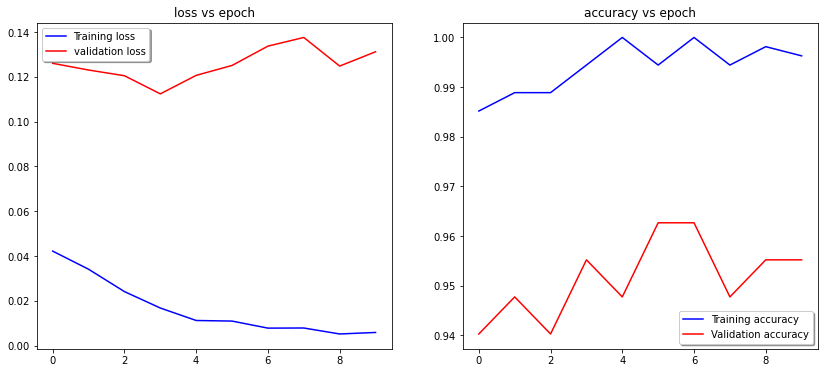

In [53]:
plotLearningCurves(history_fine) 

In [47]:
loss, accuracy = model.evaluate(ds_validation)
print("Accuracy", accuracy)
print("Loss", loss)

5/5 [==============================] - 6s 1s/step - loss: 0.1311 - binary_accuracy: 0.9552
Accuracy 0.9552238583564758
Loss 0.13113608956336975


In [48]:
loss, accuracy = model.evaluate(ds_train)
print("Accuracy", accuracy)
print("Loss", loss)

17/17 [==============================] - 25s 1s/step - loss: 0.0012 - binary_accuracy: 1.0000
Accuracy 1.0
Loss 0.001214441959746182


In [49]:
y_valid = []
for i in range (0,len(labels)):
    y_valid.append(labels[i].numpy())
y_valid = np.array(y_valid)
type(y_valid)

numpy.ndarray

In [50]:
len(y_valid)

134

In [51]:
len(predVali)

134

In [52]:
#predVali = model_1.predict(ds_validation)
predVali = (model.predict(ds_validation) > 0.0).astype("int32")
print('validation report:','\n',classification_report(y_valid, predVali))
print('validation accuracy:', accuracy_score(y_valid, predVali))

validation report: 
               precision    recall  f1-score   support

           0       0.53      0.52      0.53        65
           1       0.56      0.57      0.56        69

    accuracy                           0.54       134
   macro avg       0.54      0.54      0.54       134
weighted avg       0.54      0.54      0.54       134

validation accuracy: 0.5447761194029851


In [57]:
y_valid

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1])

In [107]:
list_y = []
for i in range(0,134):
    list_y.append(y_valid[i])

In [108]:
list_valid = []
for i in range(0,134):
    list_valid.append(predVali[i][0])

In [ ]:
logic_valid = []
for i in range(0,134):
    logic_valid.append(list_valid[i] == y_valid[i])

In [111]:
df_valid = pd.DataFrame(data = {'y_valid':list_y,'predVali':list_valid,'logic':logic_valid})

In [112]:
df_valid.head()

,y_valid,predVali,logic
0,1,0,False
1,1,0,False
2,0,0,True
3,0,0,True
4,0,1,False


In [113]:
df_valid['logic'].value_counts()

True     73
False    61
Name: logic, dtype: int64

In [115]:
df_valid['logic'][df_valid['y_valid'] == 1].value_counts()

True     39
False    30
Name: logic, dtype: int64

In [116]:
df_valid['logic'][df_valid['y_valid'] == 0].value_counts()

True     34
False    31
Name: logic, dtype: int64